<img src="http://imgur.com/1ZcRyrc.png" style="float: left; margin: 15px; height: 80px">

# Project 3

### Regression and Classification with the Ames Housing Data

---

You have just joined a new "full stack" real estate company in Ames, Iowa. The strategy of the firm is two-fold:
- Own the entire process from the purchase of the land all the way to sale of the house, and anything in between.
- Use statistical analysis to optimize investment and maximize return.

The company is still small, and though investment is substantial the short-term goals of the company are more oriented towards purchasing existing houses and flipping them as opposed to constructing entirely new houses. That being said, the company has access to a large construction workforce operating at rock-bottom prices.

This project uses the [Ames housing data recently made available on kaggle](https://www.kaggle.com/c/house-prices-advanced-regression-techniques).

In [1]:
import numpy as np
import scipy.stats as stats
import seaborn as sns
import matplotlib.pyplot as plt
import pandas as pd
import patsy

import statsmodels.formula.api as sm

from sklearn.feature_selection import SelectKBest, chi2, f_classif
from sklearn.preprocessing import StandardScaler, MinMaxScaler
from sklearn.model_selection import KFold, train_test_split
from sklearn.linear_model import LinearRegression

sns.set_style('whitegrid')

%config InlineBackend.figure_format = 'retina'
%matplotlib inline

<img src="http://imgur.com/l5NasQj.png" style="float: left; margin: 25px 15px 0px 0px; height: 25px">

## 1. Estimating the value of homes from fixed characteristics.

---

Your superiors have outlined this year's strategy for the company:
1. Develop an algorithm to reliably estimate the value of residential houses based on *fixed* characteristics.
2. Identify characteristics of houses that the company can cost-effectively change/renovate with their construction team.
3. Evaluate the mean dollar value of different renovations.

Then we can use that to buy houses that are likely to sell for more than the cost of the purchase plus renovations.

Your first job is to tackle #1. You have a dataset of housing sale data with a huge amount of features identifying different aspects of the house. The full description of the data features can be found in a separate file:

    housing.csv
    data_description.txt
    
You need to build a reliable estimator for the price of the house given characteristics of the house that cannot be renovated. Some examples include:
- The neighborhood
- Square feet
- Bedrooms, bathrooms
- Basement and garage space

and many more. 

Some examples of things that **ARE renovate-able:**
- Roof and exterior features
- "Quality" metrics, such as kitchen quality
- "Condition" metrics, such as condition of garage
- Heating and electrical components

and generally anything you deem can be modified without having to undergo major construction on the house.

---

**Your goals:**
1. Perform any cleaning, feature engineering, and EDA you deem necessary.
- Be sure to remove any houses that are not residential from the dataset.
- Identify **fixed** features that can predict price.
- Train a model on pre-2010 data and evaluate its performance on the 2010 houses.
- Characterize your model. How well does it perform? What are the best estimates of price?

> **Note:** The EDA and feature engineering component to this project is not trivial! Be sure to always think critically and creatively. Justify your actions! Use the data description file!

In [33]:
# Load the data
house = pd.read_csv('./housing.csv')

In [34]:
# A:
# LotFrontage, sub nan for 0
# Drop Alley
# MasonryType sub nan for None
# MasonryArea sub nan for 0
# Drop nan for Electrical
# Drop Fireplace
# Drop PoolQC
# Drop Fence

housed = house.drop(['Alley','FireplaceQu','PoolQC','Fence','MiscFeature'],axis=1)
housed = housed.fillna({'LotFrontage':0,'MasVnrType':'None','MasVnrArea':0})
housed = housed[housed.Electrical.isnull() != True]

# Remove NonResidential buildings 
housed = housed[housed.MSZoning !='C (all)']

# houset.isnull().sum()[houset.isnull().sum() > 0]

In [35]:
# Identify static components
# MSSubClass, MSZoning, LotFrontage, LotArea, LandContour, LotConfig
# LandSlope, Neighborhood, BldgType, HouseStyle, YearBuilt, YearRemodAdd,
# Foundation, 
# BsmtFinSF1, BsmtFinSF2, BsmtUnfSF, = TotalBsmtSF
# 1stFlrSF, 2ndFlrSF, 
# LowQualFinSF, GrLivArea, BsmtFullBath, BsmtHalfBath, FullBath, HalfBath,
# BedroomAbvGr, Kitchen, TotRmsAbvGrd,Fireplaces, 
# GarageType, GarageYrBlt, GarageArea, 
# WoodDeckSF, OpenPorchSF, EnclosedPorch, 3SsnPorch, ScreenPorch
# PoolArea


#Drop
#Neighbourhood: TOo many categories
# MSSubClass: TOo many categories
# Imbal
# MSZoning, LotConfig, BldgType, WoodDeckSF, OpenPorchSF, EnclosedPorch, 3SsnPorch
#Very imbal
# LandSlope,LandContour,LowQualFinSF, BsmtHalfBath, KitchenAbvGr, PoolArea

# ok
# HouseStyle, YearBuilt, yearRemodAdd, Foundation,TotalBsmtSF, 1stFlrSF, 2ndFlrSF
# GrLivArea, FullBath, HalfBath, BedroomAbvGr, TotRmsAbvGr, Fireplaces, GarageType,
# GarageArea, 
# Create a total porch area (even if porch types arent the same)
TotPorchSF = pd.Series(housed.WoodDeckSF + housed.OpenPorchSF + housed.EnclosedPorch + housed['3SsnPorch'] + housed.ScreenPorch)
housed['TotPorchSF'] = TotPorchSF
housed.rename(columns={'1stFlrSF':'FirstFlrSF','2ndFlrSF':'SecFlrSF'},inplace=True)
#sns.distplot(((houset.GarageYrBlt - houset.YearBuilt)[(houset.GarageYrBlt - houset.YearBuilt>0)]))

# add variables to better describe the age of the house
housed['HouseAge'] = housed['YrSold'] - housed['YearBuilt']
housed['FurnishAge'] = housed['YrSold'] - housed['YearRemodAdd']

static_col = ['HouseStyle','YrSold','Foundation',
          'TotalBsmtSF','FirstFlrSF','SecFlrSF','GrLivArea',
          'FullBath','HalfBath','BedroomAbvGr','TotRmsAbvGrd',
          'Fireplaces','GarageArea','TotPorchSF','SalePrice','GarageType',
          'CentralAir','HouseAge','FurnishAge']
houset = housed[static_col]

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                      y   R-squared:                       0.748
Model:                            OLS   Adj. R-squared:                  0.746
Method:                 Least Squares   F-statistic:                     328.1
Date:                Wed, 10 Jan 2018   Prob (F-statistic):               0.00
Time:                        15:42:25   Log-Likelihood:                -1057.2
No. Observations:                1449   AIC:                             2140.
Df Residuals:                    1436   BIC:                             2209.
Df Model:                          13                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
x1            -0.1851      0.021     -8.723      0.000      -0.227      -0.143
x2            -0.1270      0.017     -7.317      0.000      -0.161      -0.093
x3             0.1884      0.025      7.659      0.000       0.140       0.237
x4             0.1483      0.115      1.289      0.198      -0.077       0.374
x5             0.2019      0.129      1.563      0.118      -0.052       0.455
x6             0.1781      0.153      1.162      0.245      -0.122       0.479
x7            -0.0047      0.021     -0.219      0.827      -0.046       0.037
x8            -0.0169      0.019     -0.878      0.380      -0.055       0.021
x9            -0.1271      0.019     -6.586      0.000      -0.165      -0.089
x10            0.0996      0.028      3.597      0.000       0.045       0.154
x11            0.1046      0.016      6.672      0.000       0.074       0.135
x12            0.1460      0.018      8.259      0.000       0.111       0.181
x13            0.0682      0.015      4.615      0.000       0.039       0.097
==============================================================================
Omnibus:                      694.473   Durbin-Watson:                   1.983
Prob(Omnibus):                  0.000   Jarque-Bera (JB):           103344.330
Skew:                          -1.165   Prob(JB):                         0.00
Kurtosis:                      44.307   Cond. No.                         37.9
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

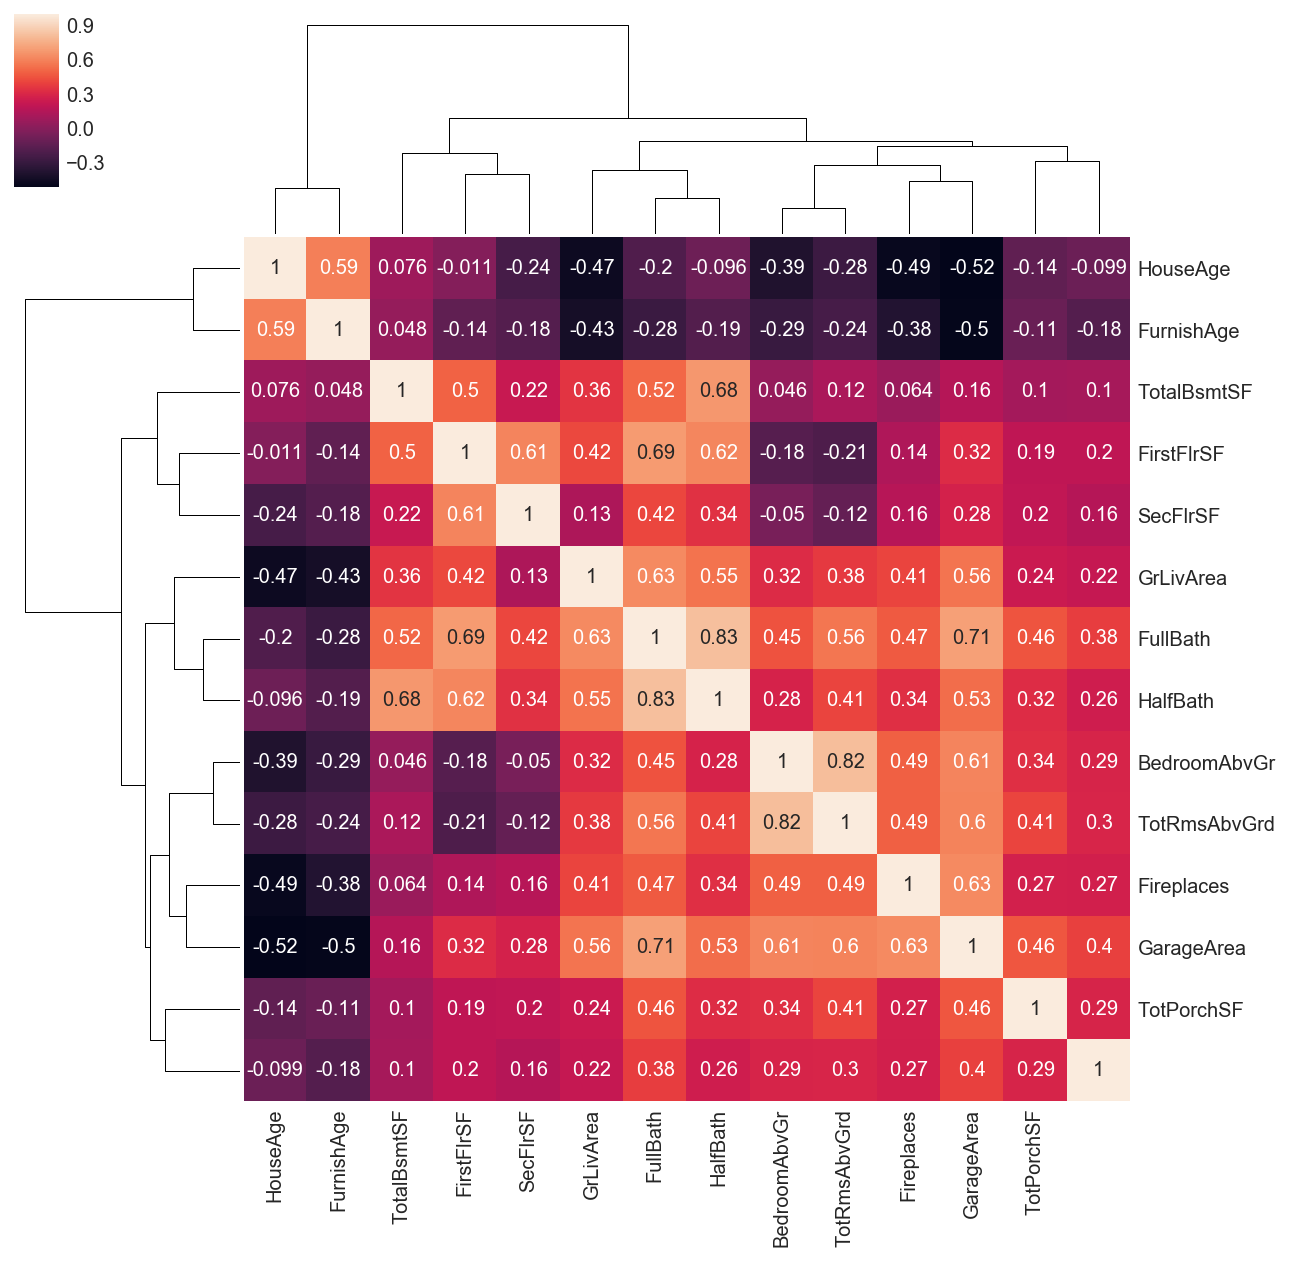

In [36]:
num_col = ['HouseAge','FurnishAge','TotalBsmtSF',
           'FirstFlrSF','SecFlrSF','GrLivArea','FullBath','HalfBath',
           'BedroomAbvGr','TotRmsAbvGrd','Fireplaces','GarageArea',
           'TotPorchSF']

sns.clustermap(houset[num_col + ['SalePrice']].corr(),xticklabels=num_col,yticklabels=num_col,annot=True)

scaler = StandardScaler()

Xs = scaler.fit_transform(houset[num_col + ['SalePrice']])
ys = Xs[:,Xs.shape[1]-1]
Xs = Xs[:,range(Xs.shape[1]-1)]


# X = houset[num_col]
# y = houset.SalePrice
model = sm.OLS(ys,Xs)
model = model.fit()
predictions = model.predict()
model.summary()


In [37]:
cat_col = ['HouseStyle','Foundation','GarageType']

formula = 'SalePrice ~ HouseStyle + Foundation + GarageType'
y2,X2 = patsy.dmatrices(formula, data = houset[cat_col+['SalePrice']], return_type='dataframe')
y2 = y2.values.ravel()

model2 = sm.OLS(y2,X2).fit()
model2.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                      y   R-squared:                       0.344
Model:                            OLS   Adj. R-squared:                  0.336
Method:                 Least Squares   F-statistic:                     41.74
Date:                Wed, 10 Jan 2018   Prob (F-statistic):          5.88e-111
Time:                        15:42:27   Log-Likelihood:                -17101.
No. Observations:                1370   AIC:                         3.424e+04
Df Residuals:                    1352   BIC:                         3.433e+04
Df Model:                          17                                         
Covariance Type:            nonrobust                                         
=========================================================================================
                            coef    std err          t      P>|t|      [0.025      0.975]
-----------------------------------------------------------------------------------------
Intercept              1.537e+05   2.73e+04      5.625      0.000       1e+05    2.07e+05
HouseStyle[T.1.5Unf]  -2.922e+04   2.02e+04     -1.447      0.148   -6.88e+04    1.04e+04
HouseStyle[T.1Story]    -47.6426   6558.300     -0.007      0.994   -1.29e+04    1.28e+04
HouseStyle[T.2.5Fin]   8.645e+04    2.7e+04      3.199      0.001    3.34e+04    1.39e+05
HouseStyle[T.2.5Unf]   3.327e+04   2.22e+04      1.497      0.135   -1.03e+04    7.69e+04
HouseStyle[T.2Story]    1.32e+04   6888.436      1.916      0.056    -317.546    2.67e+04
HouseStyle[T.SFoyer]  -1.527e+04   1.31e+04     -1.166      0.244    -4.1e+04    1.04e+04
HouseStyle[T.SLvl]    -1.625e+04   1.04e+04     -1.567      0.117   -3.66e+04    4088.711
Foundation[T.CBlock]  -8128.2251   7122.550     -1.141      0.254   -2.21e+04    5844.225
Foundation[T.PConc]    4.752e+04   7462.371      6.368      0.000    3.29e+04    6.22e+04
Foundation[T.Slab]    -3.326e+04   1.59e+04     -2.090      0.037   -6.45e+04   -2036.558
Foundation[T.Stone]    1.099e+04   2.95e+04      0.372      0.710    -4.7e+04     6.9e+04
Foundation[T.Wood]         1e+04   3.81e+04      0.262      0.793   -6.48e+04    8.48e+04
GarageType[T.Attchd]   2.375e+04   2.64e+04      0.899      0.369   -2.81e+04    7.56e+04
GarageType[T.Basment]  5212.8913   3.07e+04      0.170      0.865    -5.5e+04    6.54e+04
GarageType[T.BuiltIn]  5.665e+04   2.74e+04      2.067      0.039    2888.979     1.1e+05
GarageType[T.CarPort] -3.043e+04   3.49e+04     -0.871      0.384   -9.89e+04    3.81e+04
GarageType[T.Detchd]  -2.721e+04   2.65e+04     -1.026      0.305   -7.92e+04    2.48e+04
==============================================================================
Omnibus:                      696.932   Durbin-Watson:                   2.014
Prob(Omnibus):                  0.000   Jarque-Bera (JB):             6641.850
Skew:                           2.161   Prob(JB):                         0.00
Kurtosis:                      12.883   Cond. No.                         57.4
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

In [38]:
mmscaler = MinMaxScaler()
# mmscaler.fit_transform(houset[num_col])
houset_mm = houset.copy()
houset_mm[num_col] = mmscaler.fit_transform(houset[num_col])

formula = """
          SalePrice ~ HouseStyle + HouseAge + FurnishAge + Foundation + 
          TotalBsmtSF + FirstFlrSF + SecFlrSF + GrLivArea + 
          FullBath + HalfBath + BedroomAbvGr + TotRmsAbvGrd + 
          Fireplaces + GarageArea + TotPorchSF + GarageType + CentralAir + YrSold
          """
yn, Xn = patsy.dmatrices(formula, data=houset_mm, return_type='dataframe')


In [41]:
skb_f = SelectKBest(f_classif, k=5)
skb_chi2 = SelectKBest(chi2, k=5)

skb_f.fit(Xn.drop(['YrSold'],axis=1),yn)
skb_chi2.fit(Xn.drop(['YrSold'],axis=1),yn)

kbest = pd.DataFrame([Xn.columns, list(skb_f.scores_), list(skb_chi2.scores_)], 
                     index=['feature','f_classif','chi2 score']).T.sort_values('f_classif', ascending=False)
kbest


,feature,f_classif,chi2 score
24,GrLivArea,3.39048,42.9992
25,FullBath,2.70502,60.227
30,GarageArea,2.61601,45.6621
10,Foundation[T.Slab],2.29179,895.617
22,FirstFlrSF,2.26267,36.7445
21,TotalBsmtSF,2.23553,26.0617
19,HouseAge,2.16914,162.009
3,HouseStyle[T.2.5Fin],2.04301,869.278
28,TotRmsAbvGrd,1.90765,39.3586
9,Foundation[T.PConc],1.87361,455.394


In [49]:
# we pick first 12 features, by heuristics, 
kbestvar=14
Xn_kbest = Xn[kbest.feature.iloc[range(kbestvar)]]
Xn_kbest['YrSold'] = Xn['YrSold']


C:\Anaconda\lib\site-packages\ipykernel_launcher.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  after removing the cwd from sys.path.


In [50]:
Xn_train = Xn_kbest[Xn_kbest.YrSold < 2010]
Xn_test = Xn_kbest[Xn_kbest.YrSold >= 2010]
yn_train = yn[Xn_kbest.YrSold < 2010]
yn_test = yn[Xn_kbest.YrSold >= 2010]

lr = LinearRegression()
lr.fit(Xn_train,yn_train)
print(lr.score(Xn_train,yn_train))
print(lr.score(Xn_test,yn_test))

0.7107253054176413
0.7626785657789178


<img src="http://imgur.com/l5NasQj.png" style="float: left; margin: 25px 15px 0px 0px; height: 25px">

## 2. Determine any value of *changeable* property characteristics unexplained by the *fixed* ones.

---

Now that you have a model that estimates the price of a house based on its static characteristics, we can move forward with part 2 and 3 of the plan: what are the costs/benefits of quality, condition, and renovations?

There are two specific requirements for these estimates:
1. The estimates of effects must be in terms of dollars added or subtracted from the house value. 
2. The effects must be on the variance in price remaining from the first model.

The residuals from the first model (training and testing) represent the variance in price unexplained by the fixed characteristics. Of that variance in price remaining, how much of it can be explained by the easy-to-change aspects of the property?

---

**Your goals:**
1. Evaluate the effect in dollars of the renovate-able features. 
- How would your company use this second model and its coefficients to determine whether they should buy a property or not? Explain how the company can use the two models you have built to determine if they can make money. 
- Investigate how much of the variance in price remaining is explained by these features.
- Do you trust your model? Should it be used to evaluate which properties to buy and fix up?

In [52]:
# A:
# Non-static features
# Condition1, Condition2, OverallQual, OverallCond, RoofStyle, RoofMat,
# Exterior1st, Exterior2nd, ExterQual, ExterCond,
# BsmtQual, BsmtCond, BsmtFinType1, BsmtFinType2
# Heating, HeatingQC, Electrical
# KitchenQual, FireplaceQual, GarageQual, PoolQC, Fence, 

# Very Imbal
# Condition1, Condition2, RoofMatl, ExterCond, BsmtCond, BsmtFinType2, Heating
# Electrical, GarageQual, PoolQC, Fence
# Imbal
# RoofStyle

#OK
# OverallQual, OverallCond, Exterior1st (many categories), Exterior2nd (many categories)
# ExterQual, BsmtQual, BsmtFinType1, HeatingQC, KitchenQual
# print(housed.shape)

# Replace certain categorical with ordinal values
reno_col = ['OverallQual','OverallCond','Exterior1st','Exterior2nd',
           'ExterQual','BsmtQual','BsmtFinType1','HeatingQC','KitchenQual']
houset2 = housed[static_col + reno_col].copy()

houset2.ExterQual.replace({'Ex':5,'Gd':4,'TA':3,'Fa':2,'Po':1},inplace=True)
houset2.BsmtQual.replace({'Ex':5,'Gd':4,'TA':3,'Fa':2,'Po':1,np.NaN:0},inplace=True)
houset2.BsmtFinType1.replace({'GLQ':6,'ALQ':5,'BLQ':4,'Rec':3,'LwQ':2,'Unf':1,np.NaN:0},inplace=True)
houset2.HeatingQC.replace({'Ex':5,'Gd':4,'TA':3,'Fa':2,'Po':1},inplace=True)
houset2.KitchenQual.replace({'Ex':5,'Gd':4,'TA':3,'Fa':2,'Po':1},inplace=True)

# Get the model with just static elements
houset2[num_col] = mmscaler.fit_transform(houset2[num_col])


In [53]:
formula = 'SalePrice ~ ' + ' + '.join(static_col)

ynr, Xnr = patsy.dmatrices(formula, data=houset2, return_type='dataframe')
Xnr_train = Xn_kbest[Xn_kbest.YrSold < 2010]
Xnr_test = Xn_kbest[Xn_kbest.YrSold >= 2010]
ynr_train = yn[Xn_kbest.YrSold < 2010]
ynr_test = yn[Xn_kbest.YrSold >= 2010]

lr.fit(Xnr_train,ynr_train)
# Now that we have the original model, get the residuals
ynr_train_pred = pd.DataFrame(lr.predict(Xnr_train), columns=['SalePricePred'])
houset2_pred = houset2.join(ynr_train_pred)

In [89]:
houset2_pred['SalePriceDiff'] = houset2_pred.SalePrice - houset2_pred.SalePricePred 

houset2_reno = houset2_pred[reno_col + ['SalePrice','SalePricePred','SalePriceDiff']].copy().dropna()
formula_reno = """
            SalePriceDiff ~ OverallQual + OverallCond + 
           ExterQual + BsmtQual +BsmtFinType1 + HeatingQC + KitchenQual
                """
ynr2, Xnr2 = patsy.dmatrices(formula_reno, data=houset2_pred, return_type="dataframe")
Xnr2_train, Xnr2_test, ynr2_train, ynr2_test = train_test_split(Xnr2,
                                                        ynr2,train_size=0.75,random_state=8)
lr.fit(Xnr2_train, ynr2_train)
print('Test Score:' + str(lr.score(Xnr2_test,ynr2_test)))
print('Trained Coefficients: ' + str(lr.coef_))
print('Predicted Scoreslr.predict(Xnr2_test.head()))

0.4064832033920974
0.4192672578162093
[[    0.         32559.19885866  4592.23802005  8313.03334015
  11136.79752156  1025.37786082  2930.28928    19774.02154703]]
[[ -29921.49654515]
 [ -58670.87256544]
 [  52215.93706214]
 [ 150548.27897073]
 [-273998.07521296]]


In [91]:
# lets try to predict on the entire set of data
formula_all = 'SalePrice ~ ' + ' + '.join(static_col + reno_col)
ynra, Xnra = patsy.dmatrices(formula_all, data=houset2, return_type='dataframe')

kbestvar=16
Xnra2 = Xnra[kbest.feature.iloc[range(kbestvar)]]
Xnra2['YrSold'] = houset2['YrSold']
Xnra2[Xnr2.columns] = Xnra[Xnr2.columns]
Xnra_train = Xnra2[Xnra2.YrSold < 2010]
Xnra_test = Xnra2[Xnra2.YrSold >= 2010]
ynra_train = ynra[Xnra2.YrSold < 2010]
ynra_test = ynra[Xnra2.YrSold >= 2010]

lr = LinearRegression()
lr.fit(Xnra_train, ynra_train)
print('Test Score:' + str(lr.score(Xnra_test,ynra_test)))
print('Trained Coefficients: ' + str(lr.coef_))
print('Predicted Differentials:' + str(lr.predict(Xnra_test.head(6)))) 

C:\Anaconda\lib\site-packages\ipykernel_launcher.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  import sys


Test Score:0.801754775671351
Trained Coefficients: [[ 3.89245385e+04 -6.40278586e+03  7.12204130e+04  4.02027390e+04
   2.27327201e+05  2.09637518e+04 -1.76499791e+04  5.04229343e+02
   1.82980865e+04  8.63809903e+02  5.90935879e+03  1.00923106e+04
  -1.41838321e+04  6.78034599e+04  2.69220832e+04  1.12765273e+02
  -1.42059160e+03 -2.46018317e-10  1.46153498e+04  6.44196151e+03
   1.14275596e+04  1.14685860e+04  3.26147584e+03  1.93849757e+03
   1.04339098e+04]]
Predicted Differentials:[[153727.51465361]
 [140703.73421776]
 [126338.76718402]
 [279749.41443919]
 [170467.45152714]
 [125748.1941492 ]]


In [81]:
# we obtain 4% more 
lr.

Index([u'GrLivArea', u'FullBath', u'GarageArea', u'Foundation[T.Slab]',
       u'FirstFlrSF', u'TotalBsmtSF', u'HouseAge', u'HouseStyle[T.2.5Fin]',
       u'TotRmsAbvGrd', u'Foundation[T.PConc]', u'FurnishAge',
       u'GarageType[T.BuiltIn]', u'Foundation[T.Stone]', u'SecFlrSF',
       u'YrSold', u'Intercept', u'OverallQual', u'OverallCond', u'ExterQual',
       u'BsmtQual', u'BsmtFinType1', u'HeatingQC', u'KitchenQual'],
      dtype='object')

<img src="http://imgur.com/GCAf1UX.png" style="float: left; margin: 25px 15px 0px 0px; height: 25px">

## 3. What property characteristics predict an "abnormal" sale?

---

The `SaleCondition` feature indicates the circumstances of the house sale. From the data file, we can see that the possibilities are:

       Normal	Normal Sale
       Abnorml	Abnormal Sale -  trade, foreclosure, short sale
       AdjLand	Adjoining Land Purchase
       Alloca	Allocation - two linked properties with separate deeds, typically condo with a garage unit	
       Family	Sale between family members
       Partial	Home was not completed when last assessed (associated with New Homes)
       
One of the executives at your company has an "in" with higher-ups at the major regional bank. His friends at the bank have made him a proposal: if he can reliably indicate what features, if any, predict "abnormal" sales (foreclosures, short sales, etc.), then in return the bank will give him first dibs on the pre-auction purchase of those properties (at a dirt-cheap price).

He has tasked you with determining (and adequately validating) which features of a property predict this type of sale. 

---

**Your task:**
1. Determine which features predict the `Abnorml` category in the `SaleCondition` feature.
- Justify your results.

This is a challenging task that tests your ability to perform classification analysis in the face of severe class imbalance. You may find that simply running a classifier on the full dataset to predict the category ends up useless: when there is bad class imbalance classifiers often tend to simply guess the majority class.

It is up to you to determine how you will tackle this problem. I recommend doing some research to find out how others have dealt with the problem in the past. Make sure to justify your solution. Don't worry about it being "the best" solution, but be rigorous.

Be sure to indicate which features are predictive (if any) and whether they are positive or negative predictors of abnormal sales.

In [92]:
# A:
houset3 = housed[static_col + reno_col].copy()
houset3['isAbnormal'] = (housed['SaleCondition'] == 'Abnorml')

houset3.ExterQual.replace({'Ex':5,'Gd':4,'TA':3,'Fa':2,'Po':1},inplace=True)
houset3.BsmtQual.replace({'Ex':5,'Gd':4,'TA':3,'Fa':2,'Po':1,np.NaN:0},inplace=True)
houset3.BsmtFinType1.replace({'GLQ':6,'ALQ':5,'BLQ':4,'Rec':3,'LwQ':2,'Unf':1,np.NaN:0},inplace=True)
houset3.HeatingQC.replace({'Ex':5,'Gd':4,'TA':3,'Fa':2,'Po':1},inplace=True)
houset3.KitchenQual.replace({'Ex':5,'Gd':4,'TA':3,'Fa':2,'Po':1},inplace=True)
houset3.isAbnormal.replace({True:1, False:0}, inplace=True)

formula_abs = 'isAbnormal ~ ' + ' + '.join(static_col + reno_col)
absy, absX= patsy.dmatrices(formula_abs, data=houset3, return_type='dataframe')

SS = StandardScaler()
absXs = SS.fit_transform(absX)

absXs_train, absXs_test, absy_train, absy_test = train_test_split(absXs, absy, test_size=0.5, random_state=8)

In [93]:
#LogisticRegression neighbors 
from sklearn.linear_model import LogisticRegression, LogisticRegressionCV
logreg_cv = LogisticRegressionCV(Cs=100,cv=5,penalty='l2', scoring='accuracy',solver='liblinear',verbose=1,n_jobs=-1)
logreg_cv.fit(absXs_train, absy_train)

[Parallel(n_jobs=-1)]: Done   2 out of   5 | elapsed:    3.8s remaining:    5.8s
[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:    4.5s finished


LogisticRegressionCV(Cs=100, class_weight=None, cv=5, dual=False,
           fit_intercept=True, intercept_scaling=1.0, max_iter=100,
           multi_class='ovr', n_jobs=-1, penalty='l2', random_state=None,
           refit=True, scoring='accuracy', solver='liblinear', tol=0.0001,
           verbose=1)

In [94]:
best_C = {logreg_cv.classes_[i]:x for i, (x, c) in enumerate(zip(logreg_cv.C_, logreg_cv.classes_))}
print('best C for class:', best_C)


('best C for class:', {0.0: 0.03199267137797385})


In [95]:
logreg_1 = LogisticRegression(C=best_C[0.0], penalty='l1', solver='liblinear', multi_class = 'ovr')
logreg_1.fit(absXs_train, absy_train)
Y_1_pred = logreg_1.predict(absXs_test)

In [96]:
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score

# stores confusion matrix for Y Test and Y Pred  
conmat_1 = confusion_matrix(absy_test, Y_1_pred, labels=logreg_1.classes_)
# converts np.matrix format matrix to a dataframe and adds index and column names
conmat_1 = pd.DataFrame(conmat_1, columns=logreg_1.classes_, index=logreg_1.classes_)
print(conmat_1)
print(classification_report(absy_test, Y_1_pred))

     0.0  1.0
0.0  638    0
1.0   47    0
             precision    recall  f1-score   support

        0.0       0.93      1.00      0.96       638
        1.0       0.00      0.00      0.00        47

avg / total       0.87      0.93      0.90       685



C:\Anaconda\lib\site-packages\sklearn\metrics\classification.py:1135: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)


In [97]:
# KNN 
from sklearn.neighbors import KNeighborsClassifier
from sklearn.model_selection import GridSearchCV

knn_params = {
    'n_neighbors':[1,3,7,15,21],
    'weights':['uniform','distance'],
    'metric':['euclidean','manhattan']
}
knn_gridsearch = GridSearchCV(KNeighborsClassifier(), knn_params, cv=5, verbose=1,n_jobs=-1)
knn_gridsearch.fit(absXs_train, absy_train)
y_knn_pred = knn_gridsearch.predict(absXs_test)


Fitting 5 folds for each of 20 candidates, totalling 100 fits


[Parallel(n_jobs=-1)]: Done  34 tasks      | elapsed:   11.5s
[Parallel(n_jobs=-1)]: Done 100 out of 100 | elapsed:   12.1s finished
C:\Anaconda\lib\site-packages\sklearn\model_selection\_search.py:739: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  self.best_estimator_.fit(X, y, **fit_params)


In [98]:
knn_gridsearch.best_params_

{'metric': 'euclidean', 'n_neighbors': 7, 'weights': 'uniform'}

In [99]:
# stores confusion matrix for Y Test and Y Pred  
conmat_knn = confusion_matrix(absy_test, y_knn_pred, labels=logreg_1.classes_)
# converts np.matrix format matrix to a dataframe and adds index and column names
conmat_knn = pd.DataFrame(conmat_knn, columns=knn_gridsearch.classes_, index=knn_gridsearch.classes_)
print(conmat_knn)
print(classification_report(absy_test, y_knn_pred))

     0.0  1.0
0.0  638    0
1.0   47    0
             precision    recall  f1-score   support

        0.0       0.93      1.00      0.96       638
        1.0       0.00      0.00      0.00        47

avg / total       0.87      0.93      0.90       685



In [100]:
#SMOTE 
# try using SMOTE 
# using full data, we get 100% fscore,
# using train/test split, we get 2% fscore 
from imblearn.over_sampling import SMOTE
smote = SMOTE(random_state=8, k_neighbors=21, n_jobs=-1)
absXs_train_res, absy_train_res = smote.fit_sample(absXs, absy)
knn_gridsearch = GridSearchCV(KNeighborsClassifier(), knn_params, cv=5, verbose=1,n_jobs=-1)
knn_gridsearch.fit(absXs_train_res, absy_train_res)
y_knn_pred = knn_gridsearch.predict(absXs_test)

# stores confusion matrix for Y Test and Y Pred  
conmat_knn = confusion_matrix(absy_test, y_knn_pred, labels=logreg_1.classes_)
# converts np.matrix format matrix to a dataframe and adds index and column names
conmat_knn = pd.DataFrame(conmat_knn, columns=knn_gridsearch.classes_, index=knn_gridsearch.classes_)
print(conmat_knn)
print(classification_report(absy_test, y_knn_pred))

Fitting 5 folds for each of 20 candidates, totalling 100 fits


[Parallel(n_jobs=-1)]: Done  34 tasks      | elapsed:    7.2s
[Parallel(n_jobs=-1)]: Done 100 out of 100 | elapsed:   17.5s finished


     0.0  1.0
0.0  638    0
1.0    0   47
             precision    recall  f1-score   support

        0.0       1.00      1.00      1.00       638
        1.0       1.00      1.00      1.00        47

avg / total       1.00      1.00      1.00       685



In [117]:
#undersampling?
isNormal = houset3[houset3.isAbnormal==0]
isAb = houset3[houset3.isAbnormal==1]
isNormal_index = list(range(isNormal.shape[0]))
np.random.shuffle(isNormal_index)

#k is the proportion of normal to abnormal data
#k is 1, all algos hit about 
k = isAb.shape[0]
isNormal2 = isNormal.iloc[isNormal_index[:k]]
rework = pd.concat([isNormal2, isAb],axis=0)

In [118]:
formula_abs = 'isAbnormal ~ ' + ' + '.join(static_col + reno_col)
absy, absX= patsy.dmatrices(formula_abs, data=rework, return_type='dataframe')


absXs = SS.fit_transform(absX)
absXs_train, absXs_test, absy_train, absy_test = train_test_split(absXs, absy, test_size=0.5, random_state=8)
# absXs_train, absXs_test, absy_train, absy_test = train_test_split(absX, absy, test_size=0.5, random_state=8)

In [119]:
from sklearn.neighbors import KNeighborsClassifier
from sklearn.model_selection import GridSearchCV

knn_params = {
    'n_neighbors':[1,3,7,15,21],
    'weights':['uniform','distance'],
    'metric':['euclidean','manhattan']
}
knn_gridsearch = GridSearchCV(KNeighborsClassifier(), knn_params, cv=5, verbose=1,n_jobs=-1)
knn_gridsearch.fit(absXs_train, absy_train)
y_knn_pred = knn_gridsearch.predict(absXs_test)

Fitting 5 folds for each of 20 candidates, totalling 100 fits


[Parallel(n_jobs=-1)]: Done  34 tasks      | elapsed:   11.0s
[Parallel(n_jobs=-1)]: Done 100 out of 100 | elapsed:   11.2s finished


In [120]:
# stores confusion matrix for Y Test and Y Pred  
conmat_knn = confusion_matrix(absy_test, y_knn_pred, labels=logreg_1.classes_)
# converts np.matrix format matrix to a dataframe and adds index and column names
conmat_knn = pd.DataFrame(conmat_knn, columns=knn_gridsearch.classes_, index=knn_gridsearch.classes_)
print(knn_gridsearch.best_params_)
print(conmat_knn)
print(classification_report(absy_test, y_knn_pred))

{'n_neighbors': 21, 'metric': 'manhattan', 'weights': 'distance'}
     0.0  1.0
0.0   32   13
1.0   21   23
             precision    recall  f1-score   support

        0.0       0.60      0.71      0.65        45
        1.0       0.64      0.52      0.57        44

avg / total       0.62      0.62      0.61        89



In [121]:
#LogisticRegression with undersampling 
logreg_cv = LogisticRegressionCV(Cs=100,cv=5,penalty='l2', scoring='accuracy',solver='liblinear',verbose=1,n_jobs=-1)
logreg_cv.fit(absXs_train, absy_train)

[Parallel(n_jobs=-1)]: Done   2 out of   5 | elapsed:    1.2s remaining:    1.9s
[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:    1.9s finished


LogisticRegressionCV(Cs=100, class_weight=None, cv=5, dual=False,
           fit_intercept=True, intercept_scaling=1.0, max_iter=100,
           multi_class='ovr', n_jobs=-1, penalty='l2', random_state=None,
           refit=True, scoring='accuracy', solver='liblinear', tol=0.0001,
           verbose=1)

In [122]:
best_C = {logreg_cv.classes_[i]:x for i, (x, c) in enumerate(zip(logreg_cv.C_, logreg_cv.classes_))}
print('best C for class:', best_C)
logreg_1 = LogisticRegression(C=best_C[0.0], penalty='l1', solver='liblinear', multi_class = 'ovr')
logreg_1.fit(absXs_train, absy_train)
Y_1_pred = logreg_1.predict(absXs_test)

# stores confusion matrix for Y Test and Y Pred  
conmat_1 = confusion_matrix(absy_test, Y_1_pred, labels=logreg_1.classes_)
# converts np.matrix format matrix to a dataframe and adds index and column names
conmat_1 = pd.DataFrame(conmat_1, columns=logreg_1.classes_, index=logreg_1.classes_)
print(conmat_1)
print(classification_report(absy_test, Y_1_pred))

('best C for class:', {0.0: 0.0013530477745798076})
     0.0  1.0
0.0   45    0
1.0   44    0
             precision    recall  f1-score   support

        0.0       0.51      1.00      0.67        45
        1.0       0.00      0.00      0.00        44

avg / total       0.26      0.51      0.34        89



In [123]:
# Try smote again
# only on training data
smote = SMOTE(random_state=8, k_neighbors=21, n_jobs=-1)
absXs_train_res, absy_train_res = smote.fit_sample(absXs_train, absy_train)
knn_gridsearch = GridSearchCV(KNeighborsClassifier(), knn_params, cv=5, verbose=1,n_jobs=-1)
knn_gridsearch.fit(absXs_train_res, absy_train_res)
y_knn_pred = knn_gridsearch.predict(absXs_test)

# stores confusion matrix for Y Test and Y Pred  
conmat_knn = confusion_matrix(absy_test, y_knn_pred, labels=logreg_1.classes_)
# converts np.matrix format matrix to a dataframe and adds index and column names
conmat_knn = pd.DataFrame(conmat_knn, columns=knn_gridsearch.classes_, index=knn_gridsearch.classes_)
print(conmat_knn)
print(classification_report(absy_test, y_knn_pred))

Fitting 5 folds for each of 20 candidates, totalling 100 fits
     0.0  1.0
0.0   26   19
1.0   16   28
             precision    recall  f1-score   support

        0.0       0.62      0.58      0.60        45
        1.0       0.60      0.64      0.62        44

avg / total       0.61      0.61      0.61        89



[Parallel(n_jobs=-1)]: Done  34 tasks      | elapsed:    2.0s
[Parallel(n_jobs=-1)]: Done 100 out of 100 | elapsed:    2.1s finished


In [124]:
knn_gridsearch.best_p

KNeighborsClassifier(algorithm='auto', leaf_size=30, metric='euclidean',
           metric_params=None, n_jobs=1, n_neighbors=3, p=2,
           weights='distance')

# Final Results
k is the proportion of normal to abnormal cases
SMOTE is the 
when k = 1, F-Score for all algorithms (Logistic Regression, KNN has a F-score of ~0.5 while SMOTE-KNN has a F-score of 0.62).   
when k increases (tested for 3), F-score for algorithms decreased. Logistic Regression and KNN has a F-score of 0 while SMOTE-KNN has a F-score of 0.34. Thus SMOTE-KNN makes the outlier-detection more robust.
Under SMOTE, 